In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

In [2]:
credits=pd.read_csv('../dataset/TMDb/tmdb_5000_credits.csv')
movies=pd.read_csv('../dataset/TMDb/tmdb_5000_movies.csv')

json_columns = ['cast']
for column in json_columns:
     credits[column] = credits[column].apply(json.loads)
json_columns = ['keywords']
for column in json_columns:
     movies[column] = movies[column].apply(json.loads)

# Here we fuse the 2 datasets into one and drop all columns useless for this milestone
movie_df=credits.join(movies, rsuffix='other')

# To reduce the dataset, we filter unreleased movies and movies with a vote count inferior to 100
movie_df = movie_df[movie_df.status=='Released']
movie_df = movie_df[movie_df.vote_count >=100]
movie_df = movie_df[movie_df.original_language == 'en']
movie_df = movie_df.drop(columns=['homepage', 'id', 'original_title', 'overview', 'status', 'tagline', 'titleother','spoken_languages'])

# Reseting the index after filtering
movie_df=movie_df.reset_index(drop=True)
fits=movie_df
len(fits)
#fits.head(1)

# Creating empty column which will be filled with the id of the actors playing in each movie
fits['keywords_key']=""
fits['keywords_names']=""
#fits['genres_name']=""
#fits['genres_id']=""

# Extraction of actors ID from the cast dictionnary and adding them to the added column
print(len(fits))
for i in range(len(fits.title)): 
    strs=[]
    for ii in range(len(fits.keywords[i])):
        strs.append(fits.keywords[i][ii].get('id'))
        fits.at[i,'keywords_key']=strs
    strs=[]
    for ii in range(len(fits.keywords[i])):
        strs.append(fits.keywords[i][ii].get('name'))
        fits.at[i,'keywords_names']=strs
        
fits=fits[fits['keywords_key'].map(len) >= 8]

fits=fits.reset_index(drop=True)
print(len(fits))
fits.head(1)

3018
1572


,movie_id,title,cast,crew,budget,genres,keywords,original_language,popularity,production_companies,production_countries,release_date,revenue,runtime,vote_average,vote_count,keywords_key,keywords_names
0,19995,Avatar,"[{'cast_id': 242, 'character': 'Jake Sully', '...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de...",237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{'id': 1463, 'name': 'culture clash'}, {'id':...",en,150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,7.2,11800,"[1463, 2964, 3386, 3388, 3679, 3801, 9685, 984...","[culture clash, future, space war, space colon..."


In [3]:
# Number of nodes in the network
n_nodes = len(fits)

adjacency_key=np.zeros((n_nodes,n_nodes), dtype=float)

for i in range(n_nodes):
    if i%(np.floor(n_nodes/10)) ==0 :
        print(i,'/',n_nodes)
    for ii in range(i+1,n_nodes):
            temp=len(set(fits.keywords_key[i]).intersection(set(fits.keywords_key[ii])))
            adjacency_key[i,ii]=adjacency_key[ii,i]=temp

print(adjacency_key.max())

# We normalize by the maximum number of shared actors between two movies found in the dataset
adjacency_key = np.divide(adjacency_key,adjacency_key.max())

0 / 1572
157 / 1572
314 / 1572
471 / 1572
628 / 1572
785 / 1572
942 / 1572
1099 / 1572
1256 / 1572
1413 / 1572
1570 / 1572
23.0


In [4]:
np.save('Milestone_1/saved_adjacency_Brut.npy',adjacency_key)
fits.to_csv('Milestone_1/saved_features_Brut.csv', encoding='utf-8')

In [5]:
adjacency_key = np.load("Milestone_1/saved_adjacency_Brut.npy")
fits = pd.read_csv('Milestone_1/saved_features_Brut.csv')

0.043478260869565216
1572
1572
1570
1570


Text(0.5, 1.05, 'adjacency matrix')

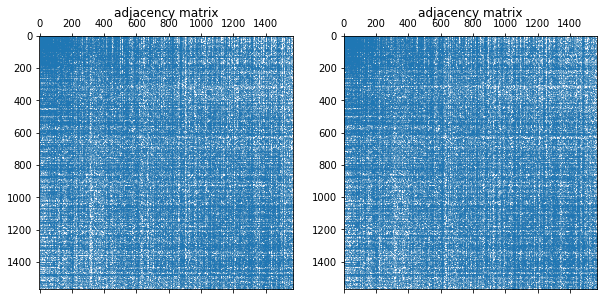

In [6]:
adjacency=adjacency_key
#adjacency[adjacency<0.01]=0
print(min(adjacency[adjacency>0]))
#adjacency[adjacency < 0.001]=0
print(len(adjacency))
print(len(fits))

# We see from the adjacency matrix that there are some movies that don't have any connections to any other movies,
# these nodes don't present any interest to us so we remove them from both the dataframe and the adjacency matrix

deg=np.sum(adjacency,0)
deg_bin=np.argwhere(deg==0).flatten()

adjacency_red = np.delete(adjacency,deg_bin,0)
adjacency_red = np.delete(adjacency_red,deg_bin,1)

fits_red=fits.loc[np.argwhere(deg>0).flatten()]

# We need to update n_nodes since we have dropped some movies
n_nodes=len(adjacency_red)

print(len(fits_red))
print(len(adjacency_red))

#adjacency=adjacency_red

# Dots represent connections between movies regardless of their weight
plt.figure(figsize=(10,20))
plt.subplot(1,2,1)
plt.spy(adjacency_red, markersize=0.1)
plt.title('adjacency matrix')
plt.subplot(1,2,2)
plt.spy(adjacency, markersize=0.1)
plt.title('adjacency matrix')

In [7]:
np.save('Milestone_1/saved_adjacency_M3.npy',adjacency_red)
fits_red.to_csv('Milestone_1/saved_features_M3.csv', encoding='utf-8')

In [8]:
# We find in the first lecture of the course the expression of L_max, the maximum number of links for a fully connected graph.
# L max is equal to the number of distinct pair of nodes present in the graph
L_max=int(n_nodes*(n_nodes-1)/2)
print('L_max = ',L_max)

# To compute L, we need to count how many non-zero elements there are in the top-right half of the adjacency matrix
L=0
for i in range(adjacency.shape[0]):
    for ii in range(i,adjacency.shape[1]):
        L+=(adjacency[i][ii]!=0)
print('L =',L)

print('Density:', L/L_max)

L_max =  1231665
L = 121581
Density: 0.09871271814982158


In [9]:
degree = np.sum(adjacency,0)
# Here we verify that there are as many elements in the degree array as there are nodes (movies) in the graph
#assert len(degree) == n_nodes

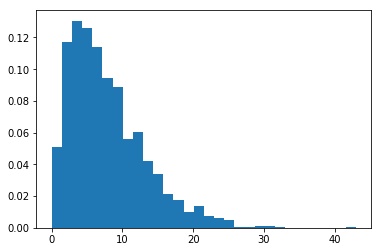

In [10]:
weights = np.ones_like(degree) / float(n_nodes)

plt.hist(degree, weights=weights, bins=30);

In [11]:
#movie_df=movie_df.drop(columns=[''])
fits_red.to_csv('features_M3.csv', encoding='utf-8')
#movie_df

In [12]:
np.save('saved_adjacency_M3',adjacency)

In [13]:
len(fits_red)

1570

In [14]:
# We implement a version of the BFS algorithm in an additional function that we will need for both questions 7 and 8

def bfs(adjacency, source_node):
    # Explored is an array where explored[a_certain_node]= 0 when this a_certain_node cannot be reached by source node
    # or = 1 when this a_certain_node can be reached
    n_nodes=len(adjacency)
    explored=np.full(n_nodes,0)
    # Store nodes to explore in a list
    to_explore = [source_node]
    
    # The source node is already explored
    explored[source_node] = 1  
    
    # Stay in loop while there are still nodes to explore
    while to_explore:
       # Pop first node frome the queue and add it to to the explored nodes
        current_node = to_explore.pop(0)
        explored[current_node] = 1
        # Copy the line of the matrix corresponding to the current node to see its connections
        neighbours = np.argwhere(adjacency[current_node]).flatten()
        
        # Set the neighbours of current_node to be explored
        for i in range(len(neighbours)):
            if not explored[neighbours[i]]:
                to_explore.append(neighbours[i])
                explored[neighbours[i]]=1
    
    return explored

In [15]:
def connected_graph(adjacency):
    """Determines whether a graph is connected.
    
    Parameters
    ----------
    adjacency: numpy array
        The (weighted) adjacency matrix of a graph.
    
    Returns
    -------
    bool
        True if the graph is connected, False otherwise.
    """
    
    # We call the previously implemented bfs function and check if the number of reached nodes starting from the
    # first node is equal to the number of nodes in the graph
    n_nodes=len(adjacency)
    connected = (len(np.argwhere(bfs(adjacency,0)))==n_nodes)
    
    return connected

In [16]:
connected_graph(adjacency)

False